In [10]:
# Creating the modeling dataset
# Data processing
import pandas as pd
import numpy as np
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Model and performance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# Oversampling and under sampling
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


from sklearn.metrics import accuracy_score, f1_score


In [11]:
# Read in data
df = pd.read_csv('df_full.csv', encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29405 entries, 0 to 29404
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   score      29405 non-null  int64 
 1   sentiment  29405 non-null  object
 2   Text       29405 non-null  object
dtypes: int64(1), object(2)
memory usage: 689.3+ KB


In [12]:
df= df[['score', "Text",'sentiment']]

In [13]:
df.head()

,score,Text,sentiment
0,1,ZUKA ZAMA! 🇺🇸🇺🇸🇺🇸❤️🤍💙,Positive
1,1,Zip ties!,Positive
2,1,Zero sugar options would be nice as well,Positive
3,1,Zendaya by cozz ft. J Cole 🐐,Positive
4,1,Zayunmmmm who are these people 🥵😍,Positive


1    27794
0     1611
Name: score, dtype: int64


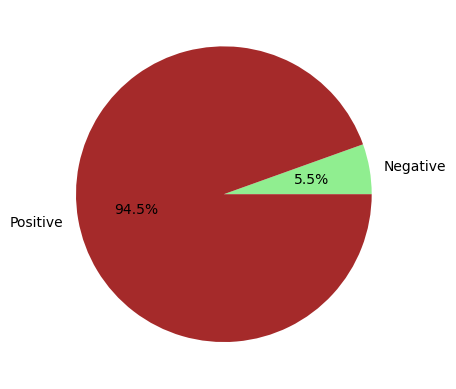

In [16]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

print(df["score"].value_counts())

pl=df.groupby('score').size().plot(kind='pie',
                                       y = "score",
                                       label = "Type",
                                       autopct='%1.1f%%',colors = ("lightgreen", "brown"),
                                labels = ['Negative','Positive'])

pl.axes.get_xaxis().set_visible(False)
pl.axes.get_yaxis().set_visible(False)

In [15]:
df['score'] =df['score'].astype('category')

In [52]:
pos_messages = df[df["score"] == 1]
neg_messages  = df[df["score"] == 0]
print(pos_messages.shape)
print(neg_messages.shape)

(27794, 3)
(1611, 3)


## Up-sampling the minority class 

In [54]:
from sklearn.utils import resample
df_upsample = resample(neg_messages,
             replace=True,
             n_samples=len(pos_messages),
             random_state=42)

print(df_upsample.shape)

(27794, 3)


1    27794
0    27794
Name: score, dtype: int64


<AxesSubplot:ylabel='Type'>

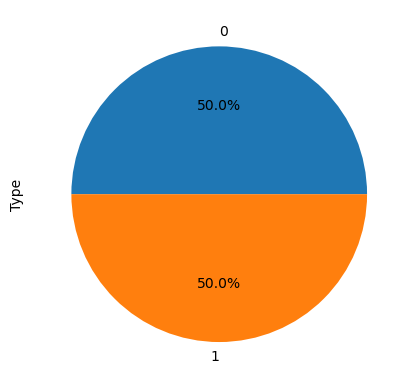

In [55]:
data_upsampled = pd.concat([pos_messages, df_upsample])

print(data_upsampled["score"].value_counts())

data_upsampled.groupby('score').size().plot(kind='pie',
                                       y = "score",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [56]:
data_upsampled.shape

(55588, 3)

In [57]:
data_upsampled.head()

,score,Text,sentiment
0,1,ZUKA ZAMA! 🇺🇸🇺🇸🇺🇸❤️🤍💙,Positive
1,1,Zip ties!,Positive
2,1,Zero sugar options would be nice as well,Positive
3,1,Zendaya by cozz ft. J Cole 🐐,Positive
4,1,Zayunmmmm who are these people 🥵😍,Positive


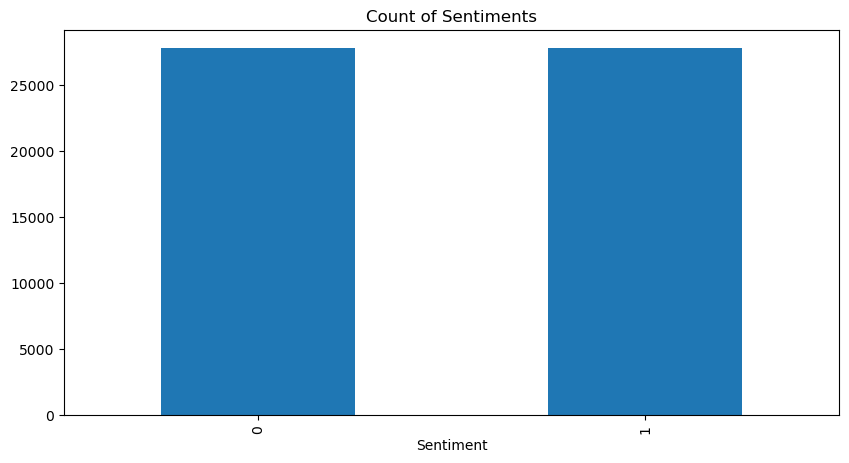

In [58]:
ax = data_upsampled['score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Sentiments',
          figsize=(10, 5))
ax.set_xlabel('Sentiment')
plt.show()

In [13]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/iremindergand/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/iremindergand/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/iremindergand/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/iremindergand/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/iremindergand/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# VADER ON UPSAMPLED DATA

In [59]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import re

sia = SentimentIntensityAnalyzer()

In [60]:
data_upsampled["Id"] = data_upsampled.index + 1

In [61]:
def text_preproc(x):
  x = re.sub(r'https*\S+', ' ', x) #remove urls
  x = re.sub(r'@\S+', ' ', x) #remove mentions
  x = re.sub(r'#\S+', ' ', x) #remove hashtags
  x = re.sub(r'\s{2,}', ' ', x) #replace over spaces
  return x

data_upsampled['clean_text'] = data_upsampled.Text.apply(text_preproc)

In [62]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(data_upsampled.iterrows(), total=len(data_upsampled)):
    text = row['clean_text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/55588 [00:00<?, ?it/s]

In [63]:
analyzer = SentimentIntensityAnalyzer()

# Calculate polarity score using Vader
def get_vader_score(sentence): 
    compound=analyzer.polarity_scores(sentence)['compound']
    if compound >= 0: 
        return 1
    #elif (compound >= -0.05) and (compound <=0.05): 
        #return None
    else: 
        return 0

data_upsampled['pred']=data_upsampled.apply(lambda x: get_vader_score(x['clean_text']), axis=1)

In [64]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(data_upsampled, how='left')
vaders['pred']=vaders['pred'].astype('category')

In [68]:
print(f'F1_score: {f1_score(vaders["score"].values, vaders["pred"].values)}')
print(f'Accuracy: {accuracy_score(vaders["score"].values, vaders["pred"].values)}')

F1_score: 0.825547308675856
Accuracy: 0.7987335396128661


In [69]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(vaders['score'], vaders['pred'])



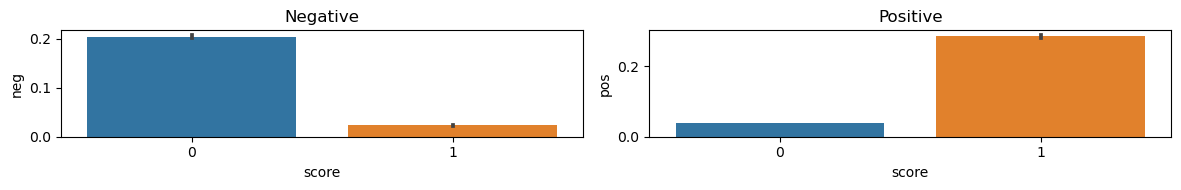

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(12, 2))
sns.barplot(data=vaders, x='score', y='pos', ax=axs[1])
#sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='score', y='neg', ax=axs[0])
axs[1].set_title('Positive')
#axs[1].set_title('Neutral')
axs[0].set_title('Negative')
plt.tight_layout()
plt.show()

In [72]:
from sklearn import metrics

y_test=vaders['score']
y_pred=vaders['pred']

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[17928  9866]
 [ 1322 26472]]


In [73]:
import seaborn as sns
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[17928  9866]
 [ 1322 26472]]


In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks


    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels,group_counts)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap='Blues',cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)




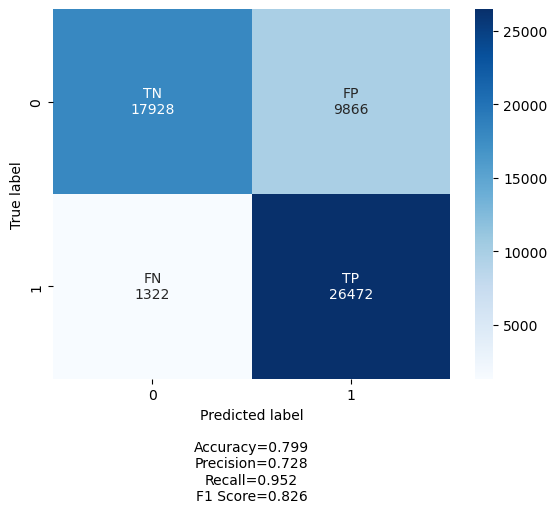

In [75]:
labels = ['TN','FP','FN','TP']
categories = ["0", "1"]
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

In [77]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.65      0.76     27794
           1       0.73      0.95      0.83     27794

    accuracy                           0.80     55588
   macro avg       0.83      0.80      0.79     55588
weighted avg       0.83      0.80      0.79     55588

